In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


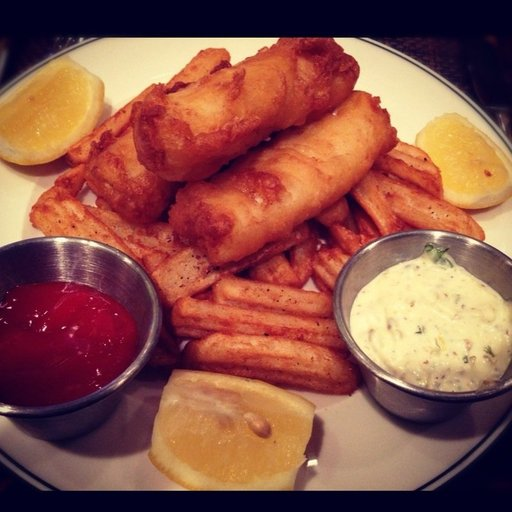

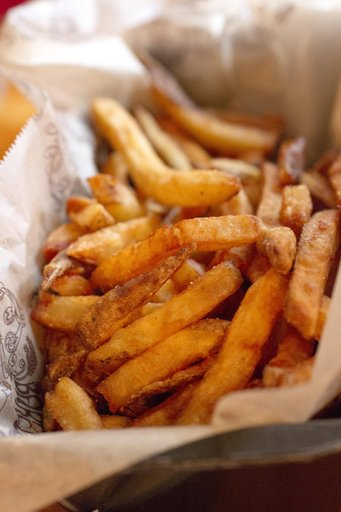

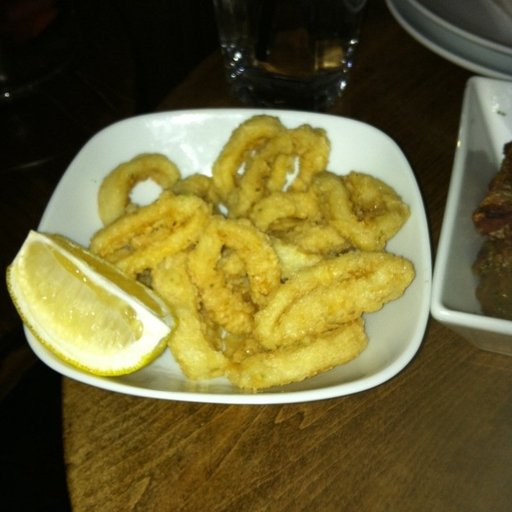

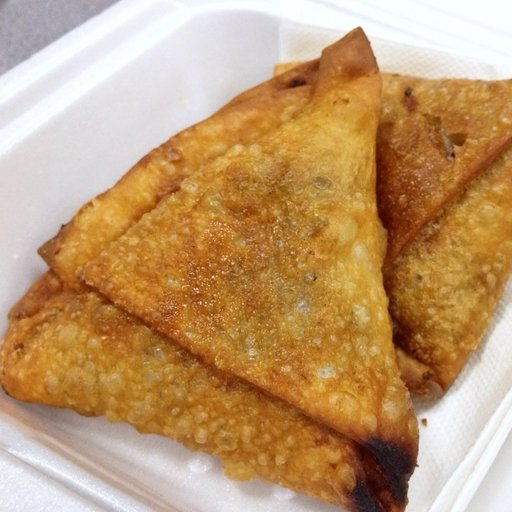

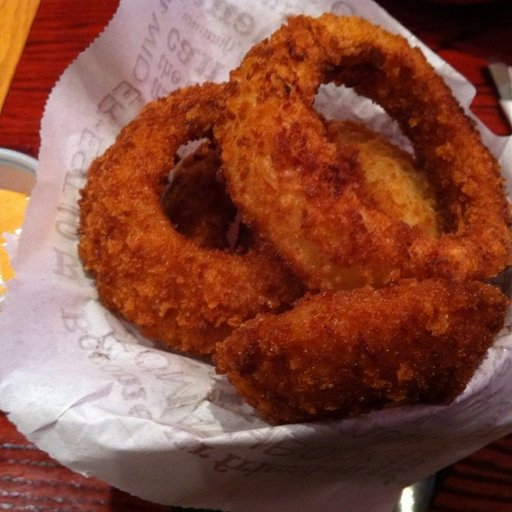

In [ ]:
import os
from IPython.display import display, Image

# Replace 'path/to/your/images/folder' with the actual path to your images folder
images_folder = '/content/drive/MyDrive/food/training/fried'

# List the files in the folder
image_files = os.listdir(images_folder)

# Display the first few images
for image_file in image_files[:5]:  # Displaying only the first 5 images
    image_path = os.path.join(images_folder, image_file)
    display(Image(filename=image_path))


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

# Define the target input size for images
target_size = (224, 224)

# Directory containing images for each category
categories = ["Rice", "Noodles-Pasta", "soup", "fried", "Dairy product"]
base_path = '/content/drive/MyDrive/food/training'

# Placeholder labels for each category
category_labels = {category: idx for idx, category in enumerate(categories)}

# List to store image file paths and corresponding labels
all_images = []
all_labels = []

# Loop through each category
for category in categories:
    category_path = os.path.join(base_path, category)
    image_files = os.listdir(category_path)

    # Append image file paths and labels for each category
    all_images.extend([os.path.join(category_path, file) for file in image_files])
    all_labels.extend([category_labels[category]] * len(image_files))

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Load the images and convert them to numpy arrays
loaded_images = [img_to_array(load_img(img_path, target_size=target_size)) for img_path in train_images]
X_train = np.array(loaded_images)
y_train = np.array(train_labels)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0

loaded_test_images = [img_to_array(load_img(img_path, target_size=target_size)) for img_path in test_images]
X_test = np.array(loaded_test_images)

# Normalize pixel values to be between 0 and 1
X_test = X_test / 255.0

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(test_labels, num_classes=5)

# Create an instance of ImageDataGenerator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on your training set
datagen.fit(X_train)

augmented_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (1731, 224, 224, 3)
Shape of X_test: (433, 224, 224, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))

# Convolutional Layer 2
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

# Convolutional Layer 4
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 5
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

# Convolutional Layer 6
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the last convolutional layer
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(512, activation='relu'))

# Output Layer
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                   

In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

steps_per_epoch = len(X_train) // 32
history=model.fit(
    augmented_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=90,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[checkpoint],
    verbose=2
)

Epoch 1/90

Epoch 1: val_accuracy improved from -inf to 0.35335, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 - 39s - loss: 1.6147 - accuracy: 0.3037 - val_loss: 1.5049 - val_accuracy: 0.3533 - 39s/epoch - 725ms/step
Epoch 2/90

Epoch 2: val_accuracy improved from 0.35335 to 0.37182, saving model to best_model.h5
54/54 - 27s - loss: 1.4851 - accuracy: 0.3514 - val_loss: 1.4444 - val_accuracy: 0.3718 - 27s/epoch - 506ms/step
Epoch 3/90

Epoch 3: val_accuracy did not improve from 0.37182
54/54 - 23s - loss: 1.4540 - accuracy: 0.3743 - val_loss: 1.4691 - val_accuracy: 0.3603 - 23s/epoch - 417ms/step
Epoch 4/90

Epoch 4: val_accuracy improved from 0.37182 to 0.39723, saving model to best_model.h5
54/54 - 24s - loss: 1.4520 - accuracy: 0.3685 - val_loss: 1.4369 - val_accuracy: 0.3972 - 24s/epoch - 437ms/step
Epoch 5/90

Epoch 5: val_accuracy did not improve from 0.39723
54/54 - 23s - loss: 1.4459 - accuracy: 0.3849 - val_loss: 1.4425 - val_accuracy: 0.3949 - 23s/epoch - 420ms/step
Epoch 6/90

Epoch 6: val_accuracy improved from 0.39723 to 0.39954, saving model to best_model.h5
54/54 - 31s - l

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model('best_model.h5')

# Evaluate the model on the test data
loss, accuracy = loaded_model.evaluate(X_test, y_test_one_hot)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Create a Sequential model
model2 = Sequential()

# Add convolutional layers
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

# Flatten the output to feed into dense layers
model2.add(Flatten())

# Add dense layers
model2.add(Dense(256, activation='relu'))
model2.add(Dense(5, activation='softmax'))  # Multi-class classification with 5 classes

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model2.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
# Fit the model using the augmented generator
history = model2.fit(
    augmented_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=(X_test, y_test_one_hot),
    validation_steps=len(test_images) // 32
)


Epoch 1/100
54/54 [==============================] - 22s 373ms/step - loss: 1.6683 - accuracy: 0.2843 - val_loss: 1.4934 - val_accuracy: 0.3580
Epoch 2/100
54/54 [==============================] - 23s 420ms/step - loss: 1.4809 - accuracy: 0.3561 - val_loss: 1.4322 - val_accuracy: 0.4065
Epoch 3/100
54/54 [==============================] - 22s 407ms/step - loss: 1.4493 - accuracy: 0.3749 - val_loss: 1.4620 - val_accuracy: 0.3533
Epoch 4/100
54/54 [==============================] - 20s 371ms/step - loss: 1.4152 - accuracy: 0.3873 - val_loss: 1.3916 - val_accuracy: 0.4111
Epoch 5/100
54/54 [==============================] - 21s 398ms/step - loss: 1.3909 - accuracy: 0.4167 - val_loss: 1.2911 - val_accuracy: 0.4619
Epoch 6/100
54/54 [==============================] - 20s 366ms/step - loss: 1.2876 - accuracy: 0.4603 - val_loss: 1.5156 - val_accuracy: 0.3718
Epoch 7/100
54/54 [==============================] - 21s 387ms/step - loss: 1.2238 - accuracy: 0.5050 - val_loss: 1.1806 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test_one_hot)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

14/14 [==============================] - 1s 30ms/step - loss: 0.4569 - accuracy: 0.8614
Test Loss: 0.4569205641746521
Test Accuracy: 0.861431896686554


In [ ]:
model2.save('model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


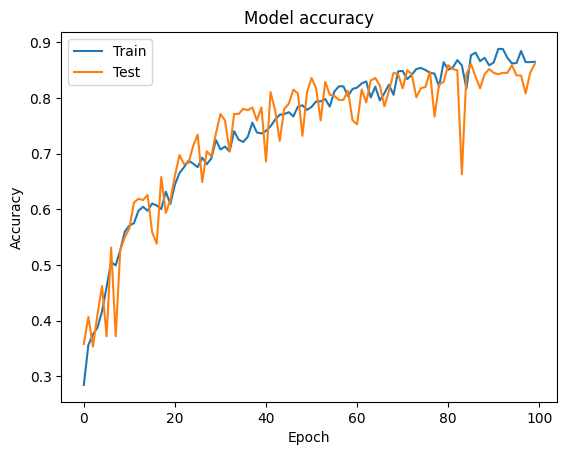

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assume that predictions are obtained using your trained model
predictions = model2.predict(X_test)

# Convert one-hot encoded labels back to numerical labels
y_test_numeric = np.argmax(y_test_one_hot, axis=1)
predictions_numeric = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_numeric, predictions_numeric)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print a classification report
print("\nClassification Report:")
print(classification_report(y_test_numeric, predictions_numeric))


14/14 [==============================] - 0s 22ms/step
Confusion Matrix:
[[49  3  1  2  1]
 [ 3 82  1  2  0]
 [ 1  4 78  4  4]
 [ 5  1  7 92  7]
 [ 3  0  5  6 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        56
           1       0.91      0.93      0.92        88
           2       0.85      0.86      0.85        91
           3       0.87      0.82      0.84       112
           4       0.86      0.84      0.85        86

    accuracy                           0.86       433
   macro avg       0.86      0.86      0.86       433
weighted avg       0.86      0.86      0.86       433



In [ ]:
from keras.preprocessing import image
import numpy as np

# Example image link
image_link = '/content/drive/MyDrive/food/training/Dairy product/156.jpg'  # Replace this with the actual path or URL

# Load the image
img = image.load_img(image_link, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Preprocess the image (normalize pixel values)
img_array = img_array / 255.0

# Make predictions
predictions = model2.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions)

if(predicted_class==0):
  print('the given item is rice!!')
elif(predicted_class==1):
  print('the given item is Noodles-Pasta!!')
elif(predicted_class==2):
  print('the given item is Soup!!')
elif(predicted_class==3):
  print('the given item is fried items!!')
elif(predicted_class==4):
  print('the given item is Dairy Products!!')


1/1 [==============================] - 0s 62ms/step
the given item is Dairy Products!!
